<a href="https://colab.research.google.com/github/ronaknavadiya/pytorch-projects-practice-/blob/main/Transfer_learning_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ronaknavadiya
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification


100%|██████████| 155M/155M [00:00<00:00, 570MB/s]  


In [9]:
import torch
from torch import nn
from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [10]:
train_df = pd.read_csv("/content/bean-leaf-lesions-classification/train.csv")
val_df = pd.read_csv("/content/bean-leaf-lesions-classification/val.csv")

train_df["image:FILE"]="/content/bean-leaf-lesions-classification/"+train_df["image:FILE"]
val_df["image:FILE"]="/content/bean-leaf-lesions-classification/"+val_df["image:FILE"]

train_df.head()

,image:FILE,category
0,/content/bean-leaf-lesions-classification/trai...,0
1,/content/bean-leaf-lesions-classification/trai...,0
2,/content/bean-leaf-lesions-classification/trai...,0
3,/content/bean-leaf-lesions-classification/trai...,0
4,/content/bean-leaf-lesions-classification/trai...,0


In [11]:
print(train_df.shape)
print(val_df.shape)

(1034, 2)
(133, 2)


In [12]:
print(train_df["category"].value_counts())
print(val_df["category"].value_counts())

category
2    348
1    345
0    341
Name: count, dtype: int64
category
2    45
0    44
1    44
Name: count, dtype: int64


In [13]:
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

In [14]:
class CustomImageDataset(Dataset):
  def __init__(self, dataframe, transform = None):
    self.dataframe = dataframe
    self.transform = transform
    self.labels = torch.tensor(dataframe["category"]).to(device)

  def __len__(self):
    return self.dataframe.shape[0]

  def __getitem__(self, idx):
    image_path = self.dataframe.iloc[idx,0]
    label = self.labels[idx]

    image = Image.open(image_path)
    if self.transform:
      image = (self.transform(image)/255.0).to(device)

    return image, label

Visulization

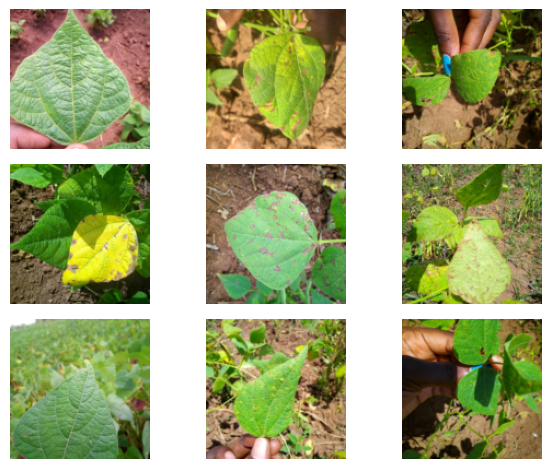

In [15]:
train_dataset = CustomImageDataset(train_df, transform = transform)
val_dataset = CustomImageDataset(val_df, transform = transform)

n_rows = 3
n_cols = 3

fif, axsArr = plt.subplots(n_rows, n_cols)

for row in range(n_rows):
  for col in range(n_cols):
    image = train_dataset[np.random.randint(0,train_dataset.__len__())][0].cpu()
    axsArr[row,col].imshow((image * 255.0).squeeze().permute(1,2,0))
    axsArr[row,col].axis("off")

plt.tight_layout()
plt.show()

In [16]:
LR = 1e-3
BATCH_SIZE = 4
EPOCH = 15


In [17]:
train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True)



In [18]:
googleNet_Model = models.googlenet(weights= "DEFAULT")

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 198MB/s]


In [19]:
for param in googleNet_Model.parameters():
  param.requires_grad = True

In [20]:
googleNet_Model.fc  # provides last layer

Linear(in_features=1024, out_features=1000, bias=True)

In [21]:
num_classes = len(train_df["category"].unique())
num_classes

3

In [22]:
googleNet_Model.fc = nn.Linear(googleNet_Model.fc.in_features, num_classes)
googleNet_Model.fc

Linear(in_features=1024, out_features=3, bias=True)

Train complete model

In [23]:
googleNet_Model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [24]:
criterian = nn.CrossEntropyLoss()
optimizer = Adam(googleNet_Model.parameters(), lr = LR)


total_loss_train_plot = []
total_acc_train_lot = []

for epoch in range(EPOCH):
  total_loss_train = 0
  total_acc_train = 0
  for data in train_dataloader:
    inputs, labels = data
    optimizer.zero_grad()

    outputs = googleNet_Model(inputs)
    train_loss = criterian(outputs, labels)
    total_loss_train += train_loss.item()

    train_loss.backward()

    optimizer.step()

    total_acc = (torch.argmax(outputs, axis = 1) == labels ).sum().item()
    total_acc_train += total_acc

  total_loss_train_plot.append(round(total_loss_train/1000,4))
  total_acc_train_lot.append(round(total_acc_train/train_dataset.__len__() * 100 ,4))

  print(f'''Epoch {epoch + 1 } / {EPOCH} , Train Loss : {round(total_loss_train/1000,4)} , Train accuracy {round((total_acc_train/train_dataset.__len__())*100,4)}  ''')


Epoch 1 / 15 , Train Loss : 0.2454 , Train accuracy 56.0928  
Epoch 2 / 15 , Train Loss : 0.2272 , Train accuracy 59.8646  
Epoch 3 / 15 , Train Loss : 0.2018 , Train accuracy 66.8279  
Epoch 4 / 15 , Train Loss : 0.1811 , Train accuracy 70.8897  
Epoch 5 / 15 , Train Loss : 0.1723 , Train accuracy 73.2108  
Epoch 6 / 15 , Train Loss : 0.1564 , Train accuracy 75.5319  
Epoch 7 / 15 , Train Loss : 0.1473 , Train accuracy 79.8839  
Epoch 8 / 15 , Train Loss : 0.1362 , Train accuracy 79.207  
Epoch 9 / 15 , Train Loss : 0.1237 , Train accuracy 82.205  
Epoch 10 / 15 , Train Loss : 0.1239 , Train accuracy 80.4642  
Epoch 11 / 15 , Train Loss : 0.109 , Train accuracy 83.8491  
Epoch 12 / 15 , Train Loss : 0.1074 , Train accuracy 83.8491  
Epoch 13 / 15 , Train Loss : 0.0956 , Train accuracy 85.4932  
Epoch 14 / 15 , Train Loss : 0.0909 , Train accuracy 87.8143  
Epoch 15 / 15 , Train Loss : 0.087 , Train accuracy 87.0406  


In [26]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0

  for data in val_dataloader:
    inputs, labels = data

    outputs = googleNet_Model(inputs)
    test_loss = criterian(outputs, labels)
    total_loss_test += test_loss.item()

    total_acc = (torch.argmax(outputs, axis = 1) == labels ).sum().item()
    total_acc_test += total_acc

In [27]:
print(f'''Test Loss : {round(total_loss_test/val_dataset.__len__(),4)} , Test accuracy {round((total_acc_test/val_dataset.__len__())*100,4)}  ''')

Test Loss : 0.0606 , Test accuracy 92.4812  


##### Transfer learning #######


In [35]:
google_transfer_model = models.googlenet(weights= "DEFAULT")

for param in google_transfer_model.parameters():
  param.requires_grad = False

google_transfer_model.fc = nn.Linear(google_transfer_model.fc.in_features, num_classes)
google_transfer_model.fc.requires_grad = True  # let only last layer to learn / do backward propogation
google_transfer_model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [37]:
criterian = nn.CrossEntropyLoss()
optimizer = Adam(google_transfer_model.parameters(), lr = LR)


total_loss_train_plot = []
total_acc_train_lot = []

for epoch in range(EPOCH):
  total_loss_train = 0
  total_acc_train = 0
  for data in train_dataloader:
    inputs, labels = data
    optimizer.zero_grad()

    outputs = google_transfer_model(inputs)
    train_loss = criterian(outputs, labels)
    total_loss_train += train_loss.item()

    train_loss.backward()



    total_acc = (torch.argmax(outputs, axis = 1) == labels ).sum().item()
    total_acc_train += total_acc

    optimizer.step()

  total_loss_train_plot.append(round(total_loss_train/1000,4))
  total_acc_train_lot.append(round(total_acc_train/train_dataset.__len__() * 100 ,4))

  print(f'''Epoch {epoch + 1 } / {EPOCH} , Train Loss : {round(total_loss_train/1000,4)} , Train accuracy {round((total_acc_train/train_dataset.__len__())*100,4)}  ''')


Epoch 1 / 15 , Train Loss : 0.2694 , Train accuracy 47.4855  
Epoch 2 / 15 , Train Loss : 0.2416 , Train accuracy 56.8665  
Epoch 3 / 15 , Train Loss : 0.2341 , Train accuracy 57.2534  
Epoch 4 / 15 , Train Loss : 0.2333 , Train accuracy 58.0271  
Epoch 5 / 15 , Train Loss : 0.2235 , Train accuracy 61.1219  
Epoch 6 / 15 , Train Loss : 0.2203 , Train accuracy 61.5087  
Epoch 7 / 15 , Train Loss : 0.2213 , Train accuracy 59.9613  
Epoch 8 / 15 , Train Loss : 0.2344 , Train accuracy 58.3172  
Epoch 9 / 15 , Train Loss : 0.2219 , Train accuracy 62.6692  
Epoch 10 / 15 , Train Loss : 0.2216 , Train accuracy 61.0251  
Epoch 11 / 15 , Train Loss : 0.2183 , Train accuracy 62.4758  
Epoch 12 / 15 , Train Loss : 0.2097 , Train accuracy 62.1857  
Epoch 13 / 15 , Train Loss : 0.2198 , Train accuracy 60.5416  
Epoch 14 / 15 , Train Loss : 0.2201 , Train accuracy 63.0561  
Epoch 15 / 15 , Train Loss : 0.2148 , Train accuracy 62.089  


In [39]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0

  for data in val_dataloader:
    inputs, labels = data

    outputs = google_transfer_model(inputs)
    test_loss = criterian(outputs, labels)
    total_loss_test += test_loss.item()

    total_acc = (torch.argmax(outputs, axis = 1) == labels ).sum().item()
    total_acc_test += total_acc

In [40]:
print(f'''Test Loss : {round(total_loss_test/val_dataset.__len__(),4)} , Test accuracy {round((total_acc_test/val_dataset.__len__())*100,4)}  ''')

Test Loss : 0.2163 , Test accuracy 63.9098  
